/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Total Loss: 5.565879042650931e+16


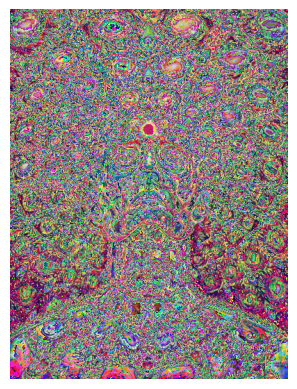

In [1]:

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load VGG19 model
vgg19 = models.vgg19(pretrained=True).features

# Freeze parameters
for param in vgg19.parameters():
    param.requires_grad = False

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19.to(device)

# Load image
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    image = in_transform(image).unsqueeze(0)
    return image.to(device)

# Get features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content representation
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Load images
content = load_image("prova_contingut.jpg")  # Single content image
style = load_image("prova_estil.jpg")  # Single style image
target_batch = content.repeat(6, 1, 1, 1).clone().requires_grad_(True)  # Creating a batch of 6 target images

# Hyperparameters
epochs = 100
optimizer = optim.Adam([target_batch], lr=0.003)
style_weights = {'conv1_1': 1., 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1
style_weight = 1e6

# Get features
content_features = get_features(content, vgg19)
style_features = get_features(style, vgg19)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Calculate loss
def calculate_losses(target_batch, content_features, style_grams, style_weights, content_weight, style_weight):
    total_loss = 0
    batch_size = target_batch.size(0)
    
    for i in range(batch_size):
        target_features = get_features(target_batch[i].unsqueeze(0), vgg19)
        style_loss = 0
        content_loss = 0
        
        # Style loss
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            style_loss += style_weights[layer] * torch.mean((target_gram - style_grams[layer]) ** 2)
        
        # Content loss
        if i == 0:  # Use the first image in the batch for content comparison
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
        
        total_loss += content_weight * content_loss + style_weight * style_loss
        
    return total_loss / batch_size

# Convert tensor to image and display
def tensor_to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss = calculate_losses(target_batch, content_features, style_grams, style_weights, content_weight, style_weight)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item()}")
        plt.figure()
        plt.imshow(tensor_to_image(target_batch[0]))
        plt.axis('off')
        plt.show()
